# Reducing the Trotter error of Hamiltonian dynamics with <span style="color:black"> multi-product formulas</span> and <span style="color:black">operator backpropagation</span>

In this notebook, you will learn how to use a  **Multi-Product Formula (MPF)** to achieve a lower Trotter error on our observable compared to the one incurred by the deepest Trotter circuit that we will actually execute.
You will do so by working through the steps of a **Qiskit pattern**:

- **Step 1: Map to quantum circuits**
    - Initialize our problem's Hamiltonian
    - <font color="blue">**Use a MPF to generate the Trotterized time-evolution circuits**</font>
- **Step 2: Optimize the problem**
    - <font color="#4589FF">**Slice the longest circuit**</font>
    - <font color="#4589FF">**Backpropagate slices from the longest circuit onto a Pauli observable**</font>
    - <font color="#4589FF">**Combine the remaining slices into a circuit with reduced depth**</font>
    - Here we transpile our circuits for `ibm_torino`
- **Step 3: Execute experiments**
    - Use the `Estimator` primitive from qiskit runtime to run our experiment on `ibm_torino`
- **Step 4: Reconstruct results**
    - <font color="blue">**Compute the MPF expectation value**</font>

## Step 1: Map to quantum problem

### 1a: Setting up our Hamiltonian

We use the XXZ model on a line of 12 sites:

$$
\hat{\mathcal{H}}_{XXZ} = \sum_{i=1}^{L-1} J_{i,(i+1)}\left(X_i X_{(i+1)}+Y_i Y_{(i+1)}+ 2\cdot Z_i Z_{(i+1)} \right) \, ,
$$

where $J_{i,(i+1)}$ is a random coefficient corresponding to edge $(i, i+1)$

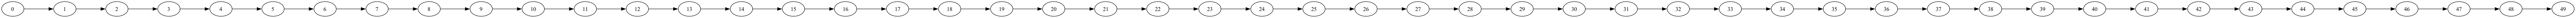

In [1]:
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw

# L = length of our 1D spin chain
L = 50

# Generate the edge-list for this spin-chain
elist = [(i-1,i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
even_edges  = elist[::2] 
odd_edges = elist[1::2]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(elist)
graphviz_draw(coupling_map.graph, method="circo")

#### Generate the hamiltonian we will evolve by

In [2]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Pauli

# Genereate random coefficients for our XXZ Hamiltonian
np.random.seed(0)
Js = np.random.rand(L-1) + 0.5*np.ones(L-1)

hamiltonian = SparsePauliOp(Pauli('I'*L))
for i, edge in enumerate(even_edges + odd_edges):
    hamiltonian += SparsePauliOp.from_sparse_list(
    [("XX", (edge), Js[i] /2),
     ("YY", (edge), Js[i] /2),
     ("ZZ", (edge), Js[i] )], 
    num_qubits=L)

print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIIIIIIII', 'IIIIIIIIIIII

#### Define the observable we want to estimate

In [3]:
observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L//2 - 1, L//2), 1.0)], num_qubits=L
)
print(observable)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


### 1b: Multi-Product Formulas

MPFs reduce the Trotter error of Hamiltonian dynamics through a weighted combination of several circuit executions.

To make this more concrete, we define an MPF as:

$$
\mu(t) = \sum_{j} x_j \rho^{k_j}_{j}\left(\frac{t}{k_j}\right) + \text{some remaining Trotter error} \, ,
$$

where $x_j$ are our weighting coefficients, $\rho^{k_j}_j$ is the density matrix corresponding to the pure state obtained by evolving the initial state with the product formula, $S^{k_j}$, involving $k_j$ Trotter steps, and $j$ indexes the number of PFs that make up the MPF.

The key here is, that the remaining Trotter error is smaller than the Trotter error that one would obtain by simply using the largest $k_j$ value!

You can view the usefulness of this from two perspectives:

1. For a fixed budget of Trotter steps that you are able to execute, you can obtain results with a Trotter error that is smaller in total.
2. Given some target number of Trotter steps that is too large to execute, you can use the MPF to find a shorter-depth circuit to run which results in a similar Trotter error.

### Choosing our Trotter steps, $k_j$

The choice of $k_j$ is up to the end-user.
In principle, any values can be chosen but some $k_j$'s will lead to a larger noise amplification on real devices than other choices.
Thus, it is important that one tries to find _"good"_ values of $k_j$.

Here, we will simply pick some fixed values for $k_j$. The rule of thumb is that $t/k_{\text{min}} \lt 1$. In our case $0.4/2 = 0.2$, so we are well-within the MPF technique's limits. If you want to learn more about this and how to choose your other $k_j$ values, refer to the respective guide: [How to choose the Trotter steps for an MPF](https://qiskit.github.io/qiskit-addon-mpf/how_tos/choose_trotter_steps.html).

In [4]:
total_time = 0.4
mpf_trotter_steps = [2,3,6]

#### Setting up the LSE

Now that we have chosen our $k_j$s, we must first construct the LSE, $Ax=b$ as explained above.
The matrix $A$ depends not only on $k_j$ but also our choice of PF, in particular its _order_.
Additionally, one may take into account whether the PF is symmetric or not (see [Carrera Vazquez et al., 2023]), by setting `symmetric=True`.
However, this is not required as shown by [Zhuk et al., 2023].

In [5]:
from qiskit_addon_mpf.static import setup_lse

lse = setup_lse(mpf_trotter_steps, order=1, symmetric=True)
mpf_coeffs = lse.solve()
print(f"The static coefficients associated with the ansatze are: {mpf_coeffs}")

The static coefficients associated with the ansatze are: [ 0.5 -2.   2.5]


### 1c: Construct each of the Trotter circuits in our MPF decomposition

At this point, we have found our expansion coefficients, $x$, and all that is left to do, is to generate the Trotterized quantum circuits.
The [qiskit_addon_utils.problem_generators](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.problem_generators.html) module with a handy function do just that:

In [6]:
# We are also going to add an extra circuit with 100 steps
trotter_steps_total = mpf_trotter_steps

In [7]:
from qiskit import QuantumCircuit
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# Generate an initial state
initial_state = QuantumCircuit(L)
for i in range(L):
    if i%2:
        initial_state.x(i)

trotter_circuits = [
    initial_state.compose(
        generate_time_evolution_circuit(
            hamiltonian,
            time=total_time,
            synthesis=LieTrotter(reps=num_steps),
        ) 
    )
    for num_steps in trotter_steps_total]

mpf_circuits = trotter_circuits[:3]
ref_circuit = trotter_circuits[-1]

fig = mpf_circuits[2].draw("mpl", fold = -1, scale = 0.2)

## Step 2a: Optimize the problem with OBP
### Create circuit slices to backpropagate

Remember, the ``backpropagate`` function will backpropagate entire circuit slices at a time, so the choice of how to slice can have an impact on how well backpropagation performs for a given problem. Here, we will group gates of the same type into slices using the [slice_by_gate_types](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.slicing.slice_by_gate_types.html) function.

For a more detailed discussion on circuit slicing, check out this [how-to guide](https://qiskit.github.io/qiskit-addon-utils/how_tos/create_circuit_slices.html) of the [qiskit-addon-utils](https://qiskit.github.io/qiskit-addon-utils/index.html) package.

In [8]:
from qiskit_addon_utils.slicing import slice_by_gate_types, combine_slices

slices = slice_by_gate_types(mpf_circuits[-1])
print(f"Separated the circuit into {len(slices)} slices.")
fig = combine_slices(slices, include_barriers=True).draw("mpl", fold = -1, scale = 0.2)

Separated the circuit into 37 slices.


### Constrain how large the operator may grow during backpropagation

During backpropagation, the number of terms in the operator will generally approach $4^N$, where $N$ is the number of qubits. The size of the operator can be bounded by specifying the ``operator_budget`` kwarg of the ``backpropagate`` function, which accepts an [OperatorBudget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.simplify.OperatorBudget.html) instance.

In [9]:
from qiskit_addon_obp.utils.simplify import OperatorBudget

op_budget = OperatorBudget(max_paulis = None,
                           max_qwc_groups= None)

### Specify your OBP error tolerance to optimize classical and quantum overhead

As our operators are back-propagated, some terms in the decomposition will have small coefficients and can be truncated without incurring much error. By allowing some amount of error budget we can reduce both the overhead of performing OBP, while also reducing the size of the observable which we obtain in the end.

Relevant parameters in this procedure are
- `max_error_total`: The total amount of error you are willing to incur
- `num_slices`: The number of slices over which to distribute the error budget
- `p_norm`: The $p$-norm in which the error is measured


In [10]:
from qiskit_addon_obp.utils.truncating import setup_budget

num_obp_slices = 10

max_error_total = 0.05
error_budget = setup_budget(max_error_total = max_error_total,
                            num_slices=num_obp_slices,
                            p_norm=2)

error_budget.per_slice_budget = [0]*(num_obp_slices-1) + [max_error_total]
# print(error_budget.per_slice_budget)

### Backpropagate slices from the circuit

First, we will specify the Pauli-Z observable on qubit 0, and we will backpropagate slices from the time-evolution circuit until the terms in the observable can no longer be combined into 8 or fewer qubit-wise commuting Pauli groups.

Below you will see that we backpropagated 7 slices but only used 6 of the 8 allotted Pauli groups. This implies that backpropagating one more slice would cause the number of Pauli groups to exceed 8. We can verify that this is the case by inspecting the returned metadata.

In [11]:
from qiskit_addon_obp import backpropagate

# Back-propagate slices onto the observable
bp_obs, remaining_slices, metadata = backpropagate(observable, 
                                                   slices[-num_obp_slices:], 
                                                   operator_budget=op_budget,
                                                   truncation_error_budget = error_budget)

# Recombine the slices remaining after back-propagation
bp_circuit = combine_slices(slices[:-num_obp_slices] + remaining_slices, include_barriers=False)

print(f"Back-propagated {metadata.num_backpropagated_slices} slices with {metadata.accumulated_error(0):.4f} accumulated error.")
print(f"New observable has {len(bp_obs.paulis)} terms, which can be combined into {len(bp_obs.group_commuting(qubit_wise=True))} qwc groups.")
#print(f"Note that back-propagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
#      f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups.")


Back-propagated 10 slices with 0.0486 accumulated error.
New observable has 15 terms, which can be combined into 9 qwc groups.


#### We can inspect OBP metadata to get more information about how the computation went
This can be useful when determining OBP input parameters, such as the desired error budget

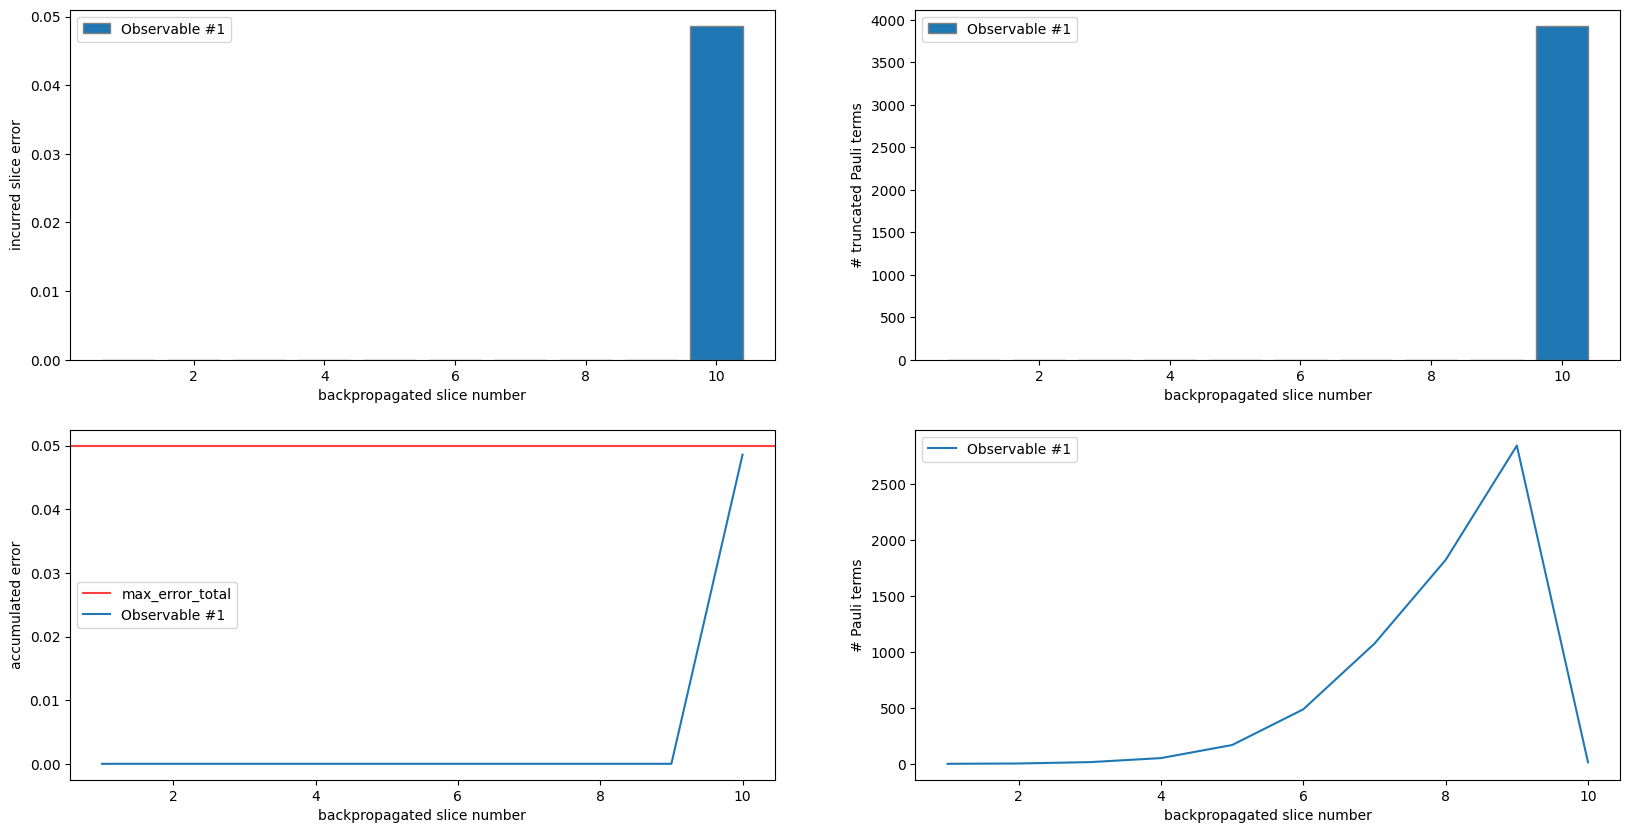

In [12]:
from matplotlib import pyplot as plt
from qiskit_addon_obp.utils.visualization import (
    plot_accumulated_error,
    plot_left_over_error_budget,
    plot_num_qwc_groups,
    plot_num_truncated_paulis,
    plot_slice_errors,
    plot_num_paulis,
    plot_sum_paulis
)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_paulis(metadata, axes[(1, 1)])
plot_num_truncated_paulis(metadata, axes[(0, 1)])

#### Before and after OBP

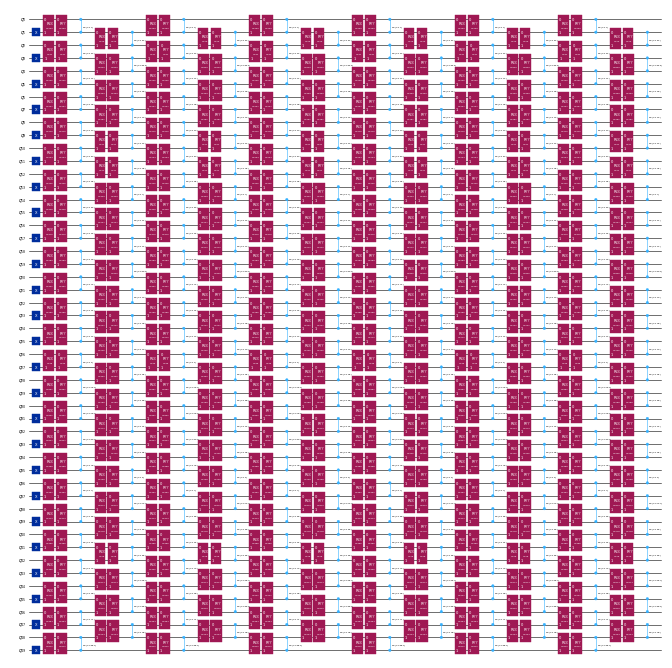

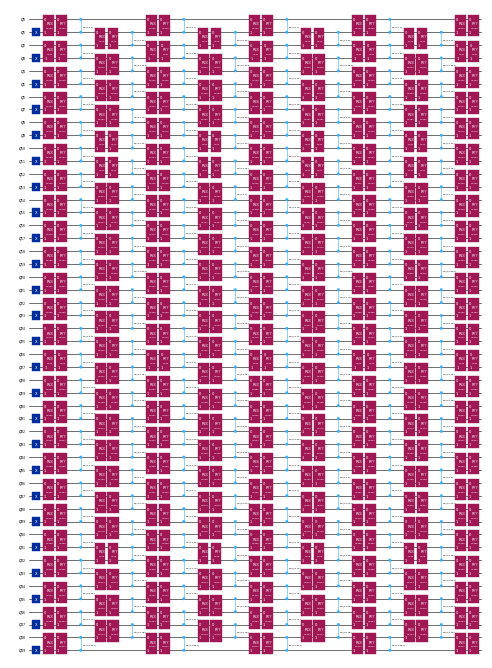

In [13]:
%matplotlib inline
long_fig = combine_slices(slices, include_barriers=False).draw("mpl", fold = -1, scale = 0.2)
short_fig = bp_circuit.draw("mpl", fold=-1, scale=0.2)

## Step 2b: Transpile circuits into ISA Circuits

#### Create PUBs (Primitives Unified Blocs) which specify our experiment
Note that this time we will not be submitting the 100 Trotter step circuit. On real hardware this will not return useful results. 

In [14]:
pub_circuits = mpf_circuits + [bp_circuit] 
pub_observables = ([observable] * 3) + [bp_obs]
pubs = list(zip(pub_circuits, pub_observables))

#### Transpile PUBs (circuits and observables) to match the backend ISA (Instruction Set Architecture)
By selecting `optimization_level=3`, the transpiler will choose a 1D chain of qubits which minimizes the noise affecting our circuit. Once we have converted our circuits into the format that the backend is prepared to accept, we will apply a complimentary transformation to our observables as well. 

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# need to create a service that's not local
service = QiskitRuntimeService(channel="ibm_quantum", instance='ibm-q-internal/dev-services/middleware')
backend = service.backend("ibm_torino")

# Transpile pubs (circuits and observables) to match ISA
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuits = [pass_manager.run(circuit) for circuit in pub_circuits]
isa_observables = [obs.apply_layout(isa_circuit.layout) 
                                if isinstance(obs, SparsePauliOp) 
                                else [sub_obs.apply_layout(isa_circuit.layout) for sub_obs in obs]
                                for (isa_circuit, obs) in zip(isa_circuits, pub_observables)]
isa_pubs = zip(isa_circuits, isa_observables)


## Step 3: Execute quantum experiments on `ibm_torino`

#### Configure ``EstimatorOptions``, to control the parameters of our hardware experiment
For more information about the available execution options, see the [qiskit-ibm-runtime documentation](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions). 

In [16]:
twirling_options = {'enable_gates' : True,
                    'enable_measure':True,
                    'num_randomizations':300,
                    'shots_per_randomization':100,
                    'strategy':'active'}

zne_options = {'amplifier': 'gate_folding',
               'noise_factors': [1, 2, 3],
               'extrapolated_noise_factors': list(np.linspace(0,3, 31)),
               'extrapolator': ["exponential", "linear", "fallback"]}

meas_learning_options = {'num_randomizations': 512,
                        'shots_per_randomization': 512}

resilience_options = {'measure_mitigation': True,
                      'zne_mitigation': True,
                      'zne': zne_options,
                      'measure_noise_learning': meas_learning_options}

experimental_options = {'execution': {'fast_parametric_update': True}}

estimator_options = {'resilience': resilience_options,
                     'twirling': twirling_options,
                     'experimental': experimental_options}

#### Execute experiments / load previous results from disk
Here is where we would initiate our experiments through runtime, however, for the purposes of this demo, we will instead be loading previously run results from disk

In [17]:
from demo_utils import dill_dump, dill_load
from qiskit_ibm_runtime import Estimator
estimator = Estimator(backend, options = estimator_options)

hw_results_save_path = f"L{L}/{'_'.join([str(k) for k in mpf_trotter_steps])}/hw_results.pkl"

# # ========== Execute Experiments =================
# hw_results = estimator.run(isa_pubs).result()
# hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]

# ========== Save Results to Disk =================
# dill_dump([hw_results_dicts, estimator_options], hw_results_save_path, make_dirs=True)

# ========== Load Results to Disk =================
hw_results_dicts, estimator_options = dill_load(hw_results_save_path)


# Re-organize expectation values
hw_expvals = [pub_result_data['evs'].tolist() for pub_result_data in hw_results_dicts]
mpf_expvals_hw = hw_expvals[:3]
mpf_obp_expvals_hw = hw_expvals[:2] + [hw_expvals[3]]

## Step 4: Reconstruct MPF expectation values

Now that we have obtained the results for our different Trotter circuits, we can reconstruct the MPF and MPF + OBP expectation values to compare them

In [18]:
mpf_expval_hw     =     mpf_expvals_hw @ mpf_coeffs
mpf_obp_expval_hw = mpf_obp_expvals_hw @ mpf_coeffs

In [19]:
# This comes from a TN calculation,
ref_expval = -0.5887371957802596 
print(f"Ideal:\t\t{ref_expval:.4f}")
print('––'*19)
print(f"{mpf_trotter_steps[0]} steps:\t{mpf_expvals_hw[0]:.4f}, |∆| = {np.abs(ref_expval - mpf_expvals_hw[0]):.4f}")
print(f"{mpf_trotter_steps[1]} steps:\t{mpf_expvals_hw[1]:.4f}, |∆| = {np.abs(ref_expval - mpf_expvals_hw[1]):.4f}")
print(f"{mpf_trotter_steps[2]} steps:\t{mpf_expvals_hw[2]:.4f}, |∆| = {np.abs(ref_expval - mpf_expvals_hw[2]):.4f}")
print(f"{mpf_trotter_steps[2]} steps + OBP:\t{mpf_obp_expvals_hw[2]:.4f}, |∆| = {np.abs(ref_expval - mpf_obp_expvals_hw[2]):.4f}")
print('––'*19)
print(f"MPF:\t\t{mpf_expval_hw:.4f}, |∆| = {np.abs(ref_expval - mpf_expval_hw):.4f}")
print(f"MPF + OBP:\t{mpf_obp_expval_hw:.4f}, |∆| = {np.abs(ref_expval - mpf_obp_expval_hw):.4f}")

Ideal:		-0.5887
––––––––––––––––––––––––––––––––––––––
2 steps:	-0.5434, |∆| = 0.0453
3 steps:	-0.5361, |∆| = 0.0527
6 steps:	-0.4161, |∆| = 0.1726
6 steps + OBP:	-0.6047, |∆| = 0.0159
––––––––––––––––––––––––––––––––––––––
MPF:		-0.2399, |∆| = 0.3488
MPF + OBP:	-0.7112, |∆| = 0.1225
